#  Clauser-Horne-Shimony-Holt (CHSH) inequality

_This notebook is an integral part of the paper [Simulating Bell inequalities with Qibo (citation to be added)](), where the popular inequalities concerning quantum Bell states are presented for educational purposes._

In the third of the series, we instantiate a quantum circuit with Qibo to study the violation of the CHSH inequality proposed in 1969, which can be written introducing the quantity $Q^S$ (cf. paper):

$$Q^S = C(\hat a, \hat c) - C(\hat a, \hat d) + C(\hat b, \hat c) + C(\hat b, \hat d)$$

Once again a local hidden (LH) variables assumption leads to the inequality:

$$|Q^S_{LH}| \leq 2$$

We will show that in a Qibo quantum circuit the inequality is violated in the case of entangled particles with specific measurement angles.

See also the [first notebook](https://github.com/qiboteam/qiboedu/tree/main/notebooks/Bell-Wigner inequality.ipynb) for the most basic Bell-Wigner inequality.


## Setup

Let's start by importing the necessary Python packages. You can install Qibo by executing `pip install qibo` in your environment, see [Qibo Quick start](https://qibo.science/qibo/stable/getting-started/quickstart.html) for further details.

In [1]:
import time
from math import pi
import numpy as np
import qibo
from qibo import Circuit, gates
import matplotlib.pyplot as plt

qibo.set_backend(backend="numpy")

[Qibo 0.2.12|INFO|2024-10-12 17:36:49]: Using numpy backend on /CPU:0


Here we instantiate a circuit with free parameters $\theta$ for the rotations before the measurement. The initial $R_Y$ gates stay with a $\theta = \pi$ rotation in order to convert a $|0\rangle$ initial state to $|1\rangle$ prior to constructing the Bell state.

In [2]:
c = Circuit(2)
c.add(gates.RY(q=0, theta=pi))
c.add(gates.RY(q=1, theta=pi))
c.add(gates.H(0))
c.add(gates.CNOT(q0=0, q1=1))
c.add(gates.RZ(q=0, theta=0))
c.add(gates.RZ(q=1, theta=0))
c.add(gates.RY(q=0, theta=0))
c.add(gates.RY(q=1, theta=0))
c.add(gates.M(0, 1))
print('%s\n' % c.draw())

[Qibo 0.2.12|WARNING|2024-10-12 17:36:49]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─RY─H─o─RZ─RY─M─
q1: ─RY───X─RZ─RY─M─



Now we define a function to run the simulation for some given values of $\phi_0$, $\phi_1$, $\theta_0$, and $\theta_1$. Similarly to the Bell case, the returned value is the _correlation_ $C(q_0, q_1) = \overline{q_0 q_1}$, which is required to compute the $Q^S$ quantity.

We also define a number of parameters for the simulation.

In [3]:
def run_circuit_C(phi_0, phi_1, th_0, th_1):
    '''run the simulation for the given choice of phi_0, phi_1, theta_0, theta_1,
       and return the correlation between the two qbits'''
    c.set_parameters([pi, pi, phi_0, phi_1, th_0, th_1])
    freqs = c(nshots=nshots).frequencies()
    # return the cross correlation: +1 when q0 = q1, -1 otherwise, averaged over all shots
    return (freqs['00'] + freqs['11'] - freqs['01'] - freqs['10']) / nshots

# parameters for the simulation
ab_steps = 6
phi_steps = 4
ac_steps = 100
nshots = 10000

Now let's run the simulation, and note the computation time. Different Qibo and hardware (e.g. GPU vs CPU) backends may yield significantly different timings.

The directions $\hat{b}, \hat{c}, \hat{d}$ are all defined with respect to $\hat{a}$, which corresponds to a direct measure with `theta=0`. We assume $\theta_{cd} = \theta_{ab}$ and $\theta_{bd} = \theta_{ac}$, therefore we have:
* $\hat{b}$ corresponds to `theta` = $\theta_{ab}$
* $\hat{c}$ corresponds to `theta` = $\theta_{ac}$
* $\hat{d}$ corresponds to `theta` = $\theta_{ab} + \theta_{ac}$


In [4]:
Q_S1 = {}
Q_S2 = {}
tstart = time.time()
for i_ab in range(ab_steps+1):
    print('Run for theta_ab = %2dpi/%d...' % (i_ab, ab_steps))

    th_ab = pi * i_ab/ab_steps    # theta_ab angles go from 0 to pi inclusive
    Q_S1[i_ab] = []
    Q_S2[i_ab] = []

    for i_ac in range(ac_steps+1):
        th_ac = pi * i_ac/ac_steps    # theta_ac angles go from 0 to pi inclusive
        th_ad = th_ab + th_ac
        C_ac = run_circuit_C(0, 0, 0, th_ac)
        C_ad = run_circuit_C(0, 0, 0, th_ad)
        C_bc = run_circuit_C(0, 0, th_ab, th_ac)
        C_bd = run_circuit_C(0, 0, th_ab, th_ad)
        Q_S1[i_ab].append(abs(C_ac - C_ad + C_bc + C_bd))
        Q_S2[i_ab].append(abs(C_ac + C_ad - C_bc + C_bd))

print('Completed in %.1f seconds' % (time.time() - tstart))
# in SWAN at CERN, this completes in 2.6 seconds on a CPU

Run for theta_ab =  0pi/6...
Run for theta_ab =  1pi/6...
Run for theta_ab =  2pi/6...
Run for theta_ab =  3pi/6...
Run for theta_ab =  4pi/6...
Run for theta_ab =  5pi/6...
Run for theta_ab =  6pi/6...
Completed in 2.6 seconds


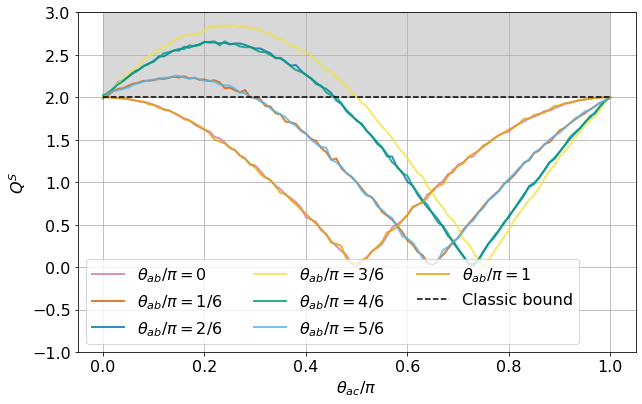

In [5]:
from qiboedu.scripts.plotscripts import plot_bell_inequalities
plot_bell_inequalities(experiment='chsh', Q_values=Q_S1, ac_steps=ac_steps, param_steps=ab_steps, param_label='\\theta_{ab}', y_bounds=(-1, 3),
                       img_width=1, savetitle='chsh_qibo_1', legendloc=3)

## Plots

Here we plot the obtained values of $Q^S$ using multiple parametric lines and common `matplotlib` primitives.

As an additional exercise, we can generate a radial plot, which better illustrates the evolution of $Q^S$ when changing $\theta_{ac}$ from 0, which corresponds to $\hat{c}$ aligned with the $z$ axis that conventionally is represented with the North direction, to $\pi$, which corresponds to $\hat{c}$ pointing to the South direction.

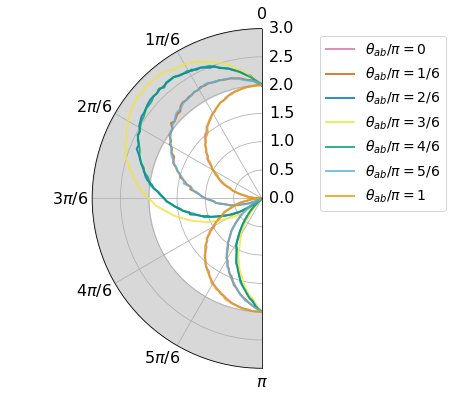

In [6]:
plot_bell_inequalities(experiment='chsh', Q_values=Q_S1, ac_steps=ac_steps, param_steps=ab_steps, param_label='\\theta_{ab}', y_bounds=(0, 3),
                       img_width=1, savetitle='chsh_qibo_2', legendloc=3, plot_projection='polar')

## Rotation around the _z_ axis

This is an alternate simulation, where for the $c$ (resp. $d$) measurement we rotate around the $z$ axis by the angle $\phi$ and then around the $y$ axis by the angle $\theta_{ac}$ (resp. $\theta_{ad}$), while we keep $\theta_{ab}$ constant.

The simulation runs over different values of $\phi$ and $\theta_{ac}$.

In [7]:
Qz_S1 = {}
tstart = time.time()

th_ab = pi/2
for i_phi in range(phi_steps+1):
    print('Run for phi = %dpi/%d...' % (i_phi, phi_steps))

    phi = pi * i_phi/phi_steps    # phi angles go from 0 to pi inclusive
    Qz_S1[i_phi] = []

    for i_ac in range(ac_steps+1):
        th_ac = pi * i_ac/ac_steps    # theta_ac angles go from 0 to pi inclusive
        th_ad = th_ab + th_ac
        C_ac = run_circuit_C(0, phi, 0, th_ac)
        C_ad = run_circuit_C(0, phi, 0, th_ad)
        C_bc = run_circuit_C(0, phi, th_ab, th_ac)
        C_bd = run_circuit_C(0, phi, th_ab, th_ad)
        Qz_S1[i_phi].append(abs(C_ac - C_ad + C_bc + C_bd))

print('Completed in %.1f seconds' % (time.time() - tstart))

Run for phi = 0pi/4...
Run for phi = 1pi/4...
Run for phi = 2pi/4...
Run for phi = 3pi/4...
Run for phi = 4pi/4...
Completed in 1.8 seconds


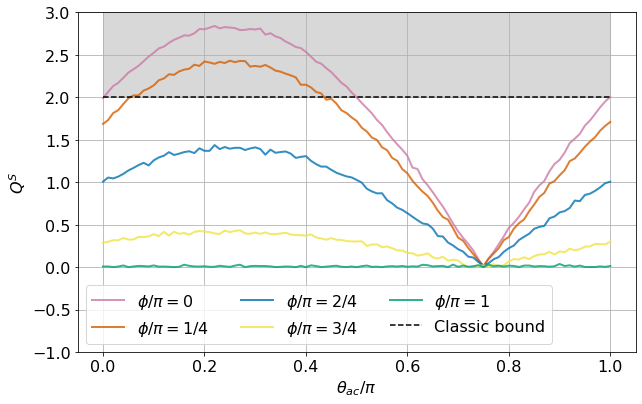

In [8]:
plot_bell_inequalities(experiment='chsh', Q_values=Qz_S1, ac_steps=ac_steps, param_steps=phi_steps, param_label='\phi', y_bounds=(-1, 3),
                       img_width=1, savetitle='chsh_qibo_3', legendloc=3)